### Langchain Agent in V1
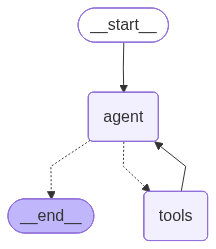

```
from langgraph.prebuilt import create_react_agent

now ->

from langchain.agents import create_agent
```

In [ ]:
# use the langchain pre-release for latest features
# pip install --pre -U langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

# Required: pip install langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv

load_dotenv()

# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with Qwen3
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434", 
    temperature=0.1
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# Chroma Vector Store (assumes data already exists from previous code)
vector_store = Chroma(
    collection_name="pdf_collection",
    embedding_function=embeddings,
    persist_directory="..\\01 Semantic Search\\chroma_db"
)

print("✓ Using Ollama qwen3 + nomic-embed-text")
print("✓ Connected to existing Chroma vector store")


✓ Using Ollama qwen3 + nomic-embed-text
✓ Connected to existing Chroma vector store


In [7]:
# ============================================================================
# VECTOR STORE VERIFICATION
# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
collection = vector_store._collection
doc_count = collection.count()
print(f"✓ Collection '{collection.name}' found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "methodology"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Page {doc.metadata.get('page', '?')}: {doc.page_content[:100]}...")


# Test 3: Check available metadata
if results:
    sample_metadata = results[0].metadata
    print(f"\n✓ Sample metadata: {sample_metadata}")

print("✓ Vector store verification complete!")



🔍 Testing Vector Store Connection...
✓ Collection 'pdf_collection' found with 593 documents

✓ Sample search for 'methodology':
  1. Page 59: involves providing accurate information and transparency about the model’s uncertainty and
limitatio...
  2. Page 60: This method could lead to biased or incomplete feedback due to the diversity of opinions
among label...
  3. Page 86: the input (e.g., the sentiment in sentiment analysis; category in classification tasks; etc.).
78Ret...

✓ Sample metadata: {'keywords': '', 'moddate': '2025-02-11T01:48:37+00:00', 'subject': '', 'total_pages': 174, 'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'page': 59, 'start_index': 3525, 'title': '', 'trapped': '/False', 'page_label': '60', 'author': '', 'source': 'https://arxiv.org/pdf/2501.04040.pdf', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'creationdate': '2025-02-11T01:48:37+00:00'}
✓ Vector store verification complete

In [ ]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve relevant information from the document to answer the query."""
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content, docs

# ============================================================================
# AGENT CREATION
# ============================================================================
# Tools for the agent (single tool only)
tools = [retrieve_context]

# Agent prompt - simplified for single tool
prompt = """You are a research assistant with a document retrieval tool.

Tool:
- retrieve_context: Search the document for relevant information

Always use the tool to find relevant information before answering.
Cite page numbers and be thorough."""


✓ Agentic RAG ready!


In [12]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, prompt=prompt)


In [ ]:
rag_agent

response = rag_agent.invoke({'messages': "What are the main methods mentioned in this paper?"})

🔍 Searching: 'main methods'
✓ Found 4 relevant chunks


In [19]:
response

{'messages': [HumanMessage(content='What are the main methods mentioned in this paper?', additional_kwargs={}, response_metadata={}, id='196667ab-5349-43a7-87fe-b29e72f758c2'),
  AIMessage(content='<think>\nOkay, the user is asking about the main methods mentioned in the paper. Since I need to use the retrieve_context tool, I should start by calling that function with the query specifically asking for the main methods. The tool will search the document and return relevant information. I have to make sure to cite page numbers and be thorough in the answer. Let me structure the tool call correctly.\n</think>\n\n', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-09-21T11:35:04.4331886Z', 'done': True, 'done_reason': 'stop', 'total_duration': 864400800, 'load_duration': 48579100, 'prompt_eval_count': 194, 'prompt_eval_duration': 164461900, 'eval_count': 110, 'eval_duration': 650697800, 'model_name': 'qwen3'}, id='run--a4bb414a-b7dc-438c-899d-6735f18f1402-0', 

In [ ]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [10]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
# ask("What are the main methods mentioned in this paper?")


# # Test multi-step reasoning
ask("First find the methodology, then look for evaluation results.")



Question: First find the methodology, then look for evaluation results.

💬 Answer:
First find the methodology, then look for evaluation results.

🔧 Using: retrieve_context with {'query': 'methodology'}

🔧 Using: retrieve_context with {'query': 'evaluation results'}
🔍 Searching: 'methodology'
🔍 Searching: 'evaluation results'
✓ Found 4 relevant chunks
✓ Found 4 relevant chunks

💬 Answer:
Page 60: a crucial role in providing feedback on the model’s outputs. Ensuring that labellers have
adequate qualifications is vital; despite stringent selection criteria, mismatches in intentions
between researchers and labellers can still occur, potentially compromising feedback quality
and LLM performance [106]. To address this, the InstructGPT initiative includes a screening
process to select labellers whose evaluations closely align with those of researchers [205]. In
some studies, using “super raters” ensures the highest quality of feedback by selecting the most
consistent labellers for critical t

In [11]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit' to exit

Question: what is rag

💬 Answer:
what is rag

🔧 Using: retrieve_context with {'query': 'what is rag'}
🔍 Searching: 'what is rag'
✓ Found 4 relevant chunks

💬 Answer:
Page 122: Benchmarks such as SQuAD [33], Natural Questions [71], and specialized datasets for re-
trieval tasks are widely used for assessment.
Despite its promise, RAG faces several challenges:
1. Retrieval Latency: Efficiently querying large databases in real time remains a technical
hurdle.
2. Data Quality: The reliability of generated outputs depends heavily on the quality of
retrieved data.
3. Scalability: Handling large-scale retrieval tasks while maintaining high generation quality
is complex.
Future research avenues include:
• Expanding RAG frameworks to support multi-modal inputs, such as text, images, and
audio.
• Enhancing retrieval efficiency through novel indexing and search techniques.
• Improving integration mechanisms for tighter coupling between retrieval and gene

KeyboardInterrupt: Interrupted by user